In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Загружаем YOLO
weights_path = "/content/sample_data/yolov3.weights"  # путь к весам модели YOLOv3
config_path = "/content/sample_data/yolov3.cfg"       # путь к конфигурации модели
class_names_path = "/content/sample_data/coco.names"  # путь к файлу с именами классов



In [2]:
# Загрузить классы объектов из COCO
with open(class_names_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]

# Создаём нейронную сеть YOLO с использованием OpenCV
net = cv2.dnn.readNet(weights_path, config_path)

# Используем GPU/CPU
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Функция для выполнения предсказания YOLO
def detect_objects_yolo(image):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    outputs = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                box_width = int(detection[2] * width)
                box_height = int(detection[3] * height)

                x = int(center_x - box_width / 2)
                y = int(center_y - box_height / 2)

                boxes.append([x, y, box_width, box_height])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

    result_image = image.copy()
    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
            color = (0, 255, 0)

            cv2.rectangle(result_image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(result_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return result_image




In [3]:
folder_path = "/content/sample_data/dataset"
# Получаем список изображений из папки
image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg'))]

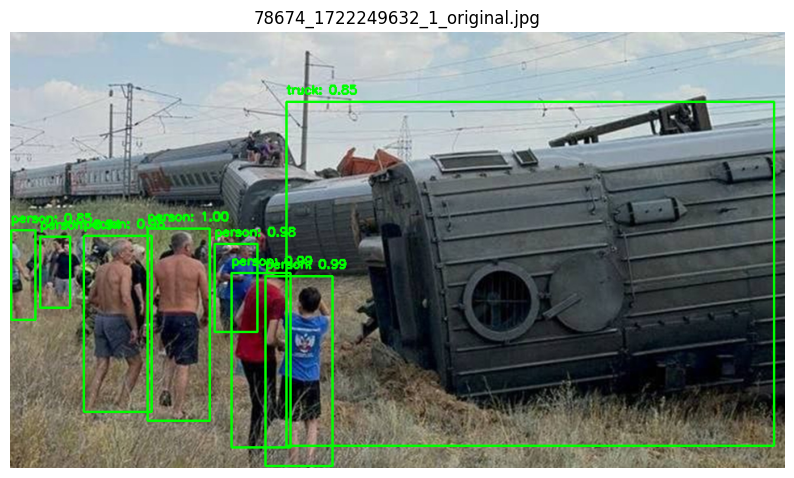

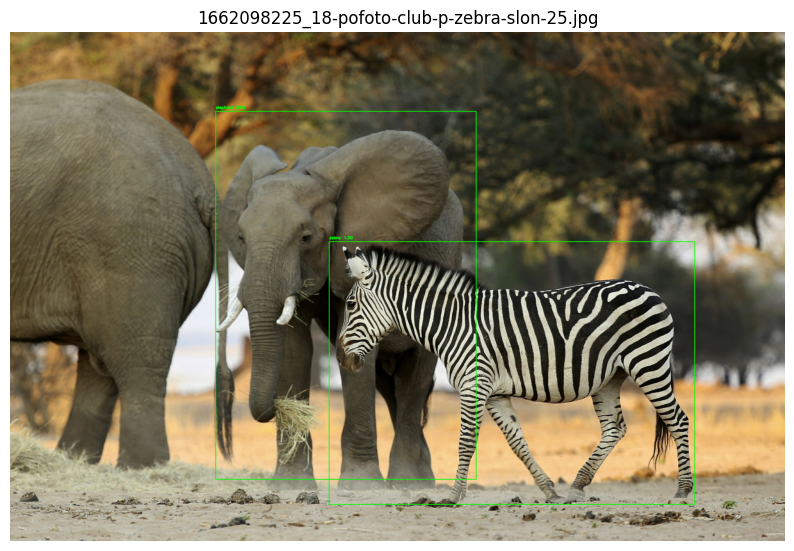

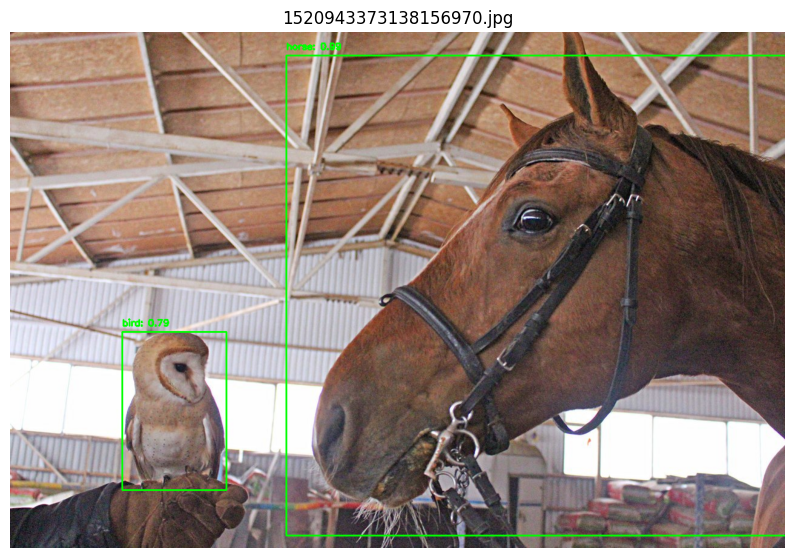

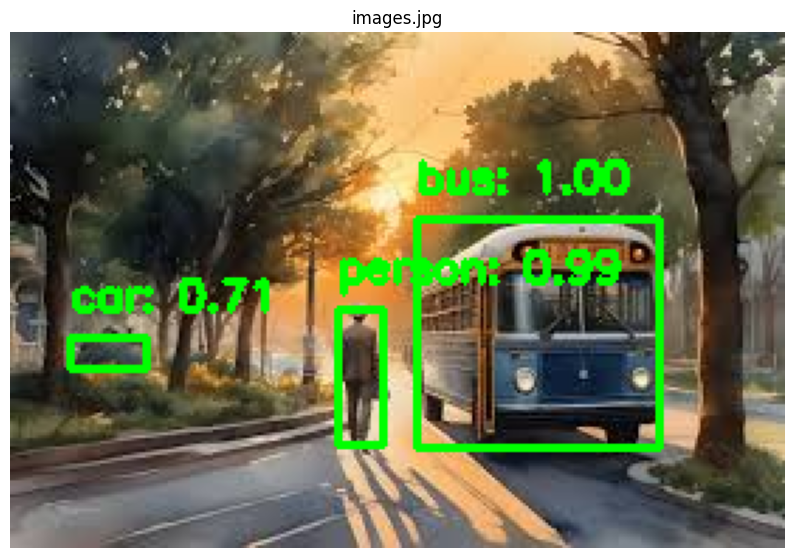

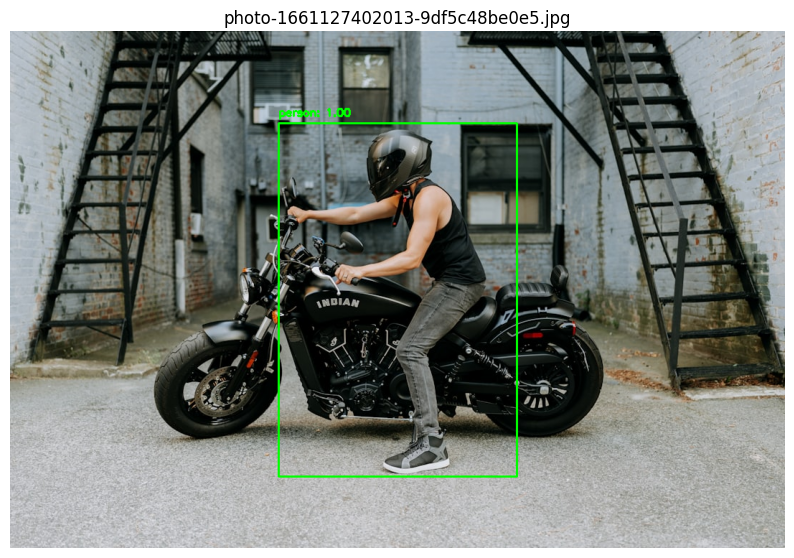

In [4]:
# Обрабатываем каждое изображение в папке
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)  # Полный путь к изображению
    image = cv2.imread(image_path)  # Читаем изображение
     # Выполняем детекцию объектов
    result_image = detect_objects_yolo(image)
    # Отображаем результат с помощью Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Убирает оси
    plt.title(image_file)  # Заголовок изображения
    plt.show()